In [123]:
import torch

In [124]:
torch.finfo(torch.float32)

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

In [125]:
from transformers import GPT2Tokenizer, GPT2Model
from lovely_tensors import monkey_patch

monkey_patch()
import torch
from torch import no_grad

In [126]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
text = " nothing nothing nothing nothing king man queen woman puppy puppy"
encoded_input = tokenizer(text, return_tensors="pt")

In [127]:
input_ids = encoded_input["input_ids"]
input_ids

tensor[1, 10] i64 x∈[582, 26188] μ=8.638e+03 σ=1.033e+04 [[2147, 2147, 2147, 2147, 5822, 582, 16599, 2415, 26188, 26188]]

In [128]:
input_embeddings = model.wte(input_ids)
input_embeddings

tensor[1, 10, 768] n=7680 (30Kb) x∈[-0.720, 0.461] μ=0.000 σ=0.121 grad EmbeddingBackward0

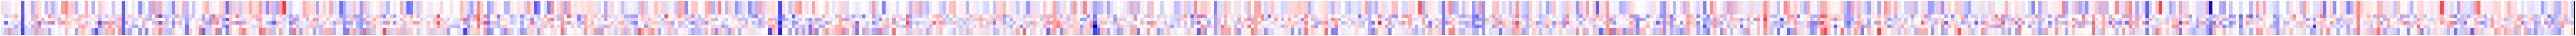

In [129]:
input_embeddings.squeeze().chans(scale=10, cmap="seismic")

In [130]:
pos_ids = torch.arange(0, input_embeddings.size(-2))[None]
pos_ids

tensor[1, 10] i64 x∈[0, 9] μ=4.500 σ=3.028 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [131]:
pos_embeddings = model.wpe(pos_ids)
pos_embeddings

tensor[1, 10, 768] n=7680 (30Kb) x∈[-4.538, 4.065] μ=-0.002 σ=0.184 grad EmbeddingBackward0

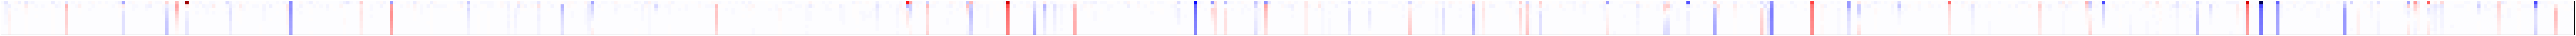

In [132]:
(pos_embeddings.squeeze() / pos_embeddings.squeeze().abs().max()).chans(scale=10, cmap="seismic")

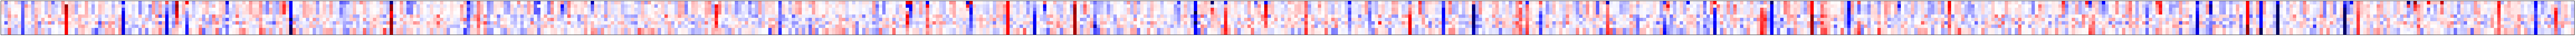

In [133]:
hidden_state_1 = input_embeddings + pos_embeddings
hidden_state_1.squeeze().chans(scale=10, cmap="seismic")

In [134]:
block0 = model.h[0]
block0

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

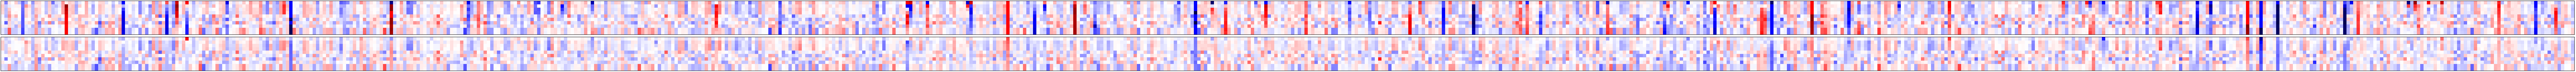

In [135]:
hidden_state_ln1 = block0.ln_1(hidden_state_1)
hs1 = hidden_state_1.squeeze()
ln1 = hidden_state_ln1.squeeze()
torch.cat([hs1, ln1], dim=0).reshape(2, *ln1.shape).chans(scale=10, cmap="seismic")

# .chans(scale=10, cmap="seismic")

In [136]:
attn_0 = block0.attn
q, k, v = attn_0.c_attn(hidden_state_ln1).split(768, dim=2)
q, k, v

# .squeeze().chans(scale=10, cmap="seismic")

(tensor[1, 10, 768] n=7680 (30Kb) x∈[-4.949, 3.822] μ=-0.083 σ=0.971 grad SplitBackward0,
 tensor[1, 10, 768] n=7680 (30Kb) x∈[-6.153, 6.964] μ=0.034 σ=1.383 grad SplitBackward0,
 tensor[1, 10, 768] n=7680 (30Kb) x∈[-1.561, 1.112] μ=-0.000 σ=0.219 grad SplitBackward0)

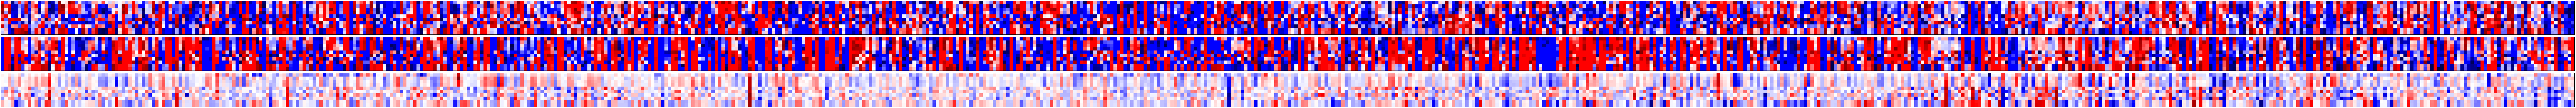

In [137]:
torch.cat([q, k, v], dim=0).reshape(3, *q.shape).squeeze().chans(scale=10, cmap="seismic")

In [138]:
q_split = attn_0._split_heads(q, 12, 64)
q_split

tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-4.949, 3.822] μ=-0.083 σ=0.971 grad PermuteBackward0

In [139]:
k_split = attn_0._split_heads(k, 12, 64)
v_split = attn_0._split_heads(v, 12, 64)

In [140]:
k,q,v

(tensor[1, 10, 768] n=7680 (30Kb) x∈[-6.153, 6.964] μ=0.034 σ=1.383 grad SplitBackward0,
 tensor[1, 10, 768] n=7680 (30Kb) x∈[-4.949, 3.822] μ=-0.083 σ=0.971 grad SplitBackward0,
 tensor[1, 10, 768] n=7680 (30Kb) x∈[-1.561, 1.112] μ=-0.000 σ=0.219 grad SplitBackward0)

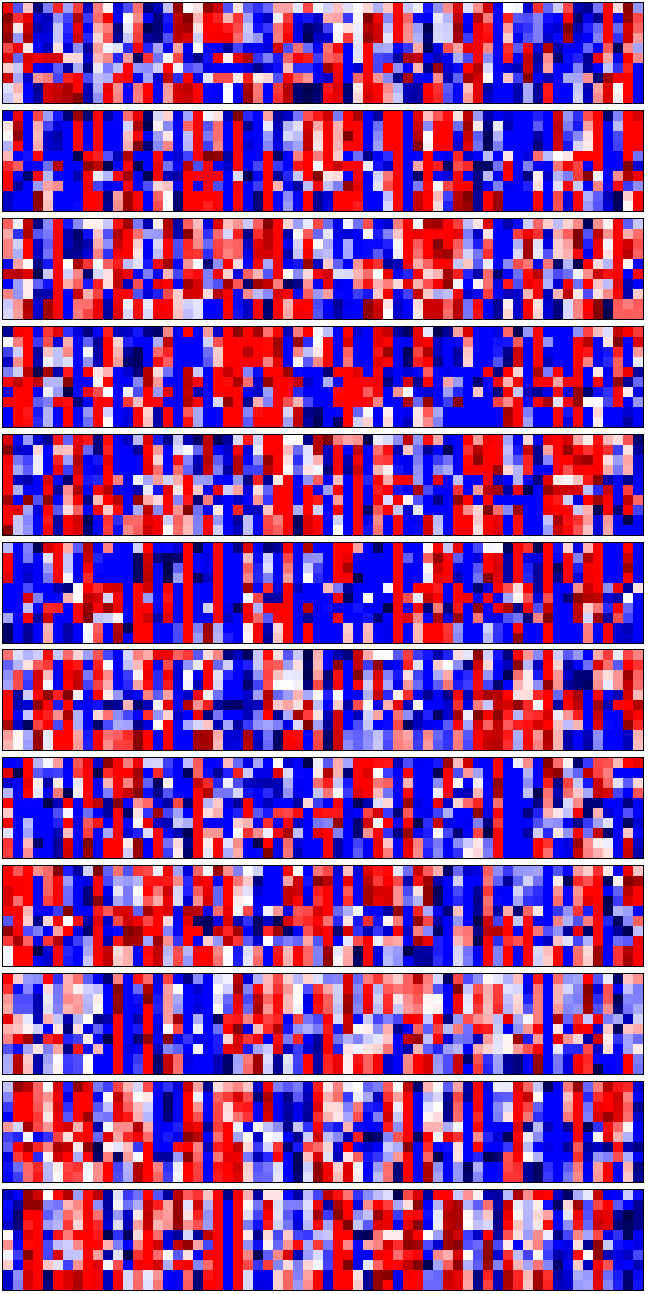

In [141]:
q_split.squeeze().chans(scale=10, cmap="seismic")

In [142]:
attn_weights = torch.matmul(q_split, k_split.transpose(-1, -2))
attn_weights

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-71.989, 115.081] μ=-1.210 σ=26.638 grad UnsafeViewBackward0

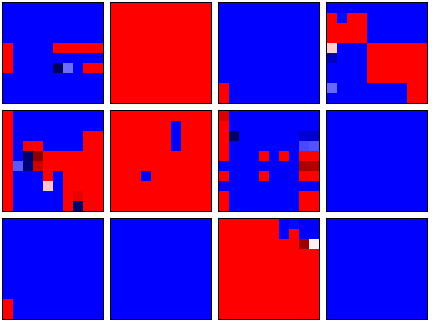

In [143]:
attn_weights.squeeze().chans(scale=10, cmap="seismic")

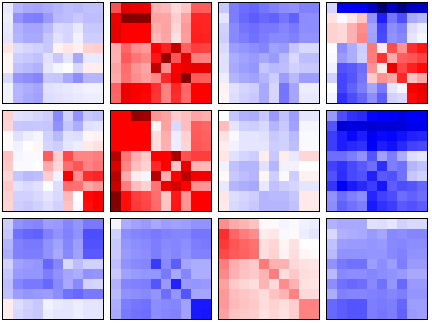

In [144]:
(attn_weights / (10 * torch.sqrt(torch.tensor(64)))).squeeze().chans(scale=10, cmap="seismic")

In [145]:
scaled_down_attn_weights = attn_weights / 8 # ( / torch.sqrt(torch.tensor(64)))
scaled_down_attn_weights

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-8.999, 14.385] μ=-0.151 σ=3.330 grad DivBackward0

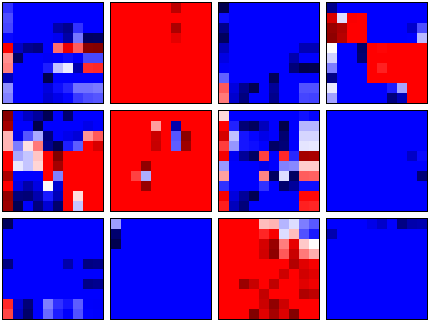

In [146]:
scaled_down_attn_weights.squeeze().chans(scale=10, cmap="seismic")

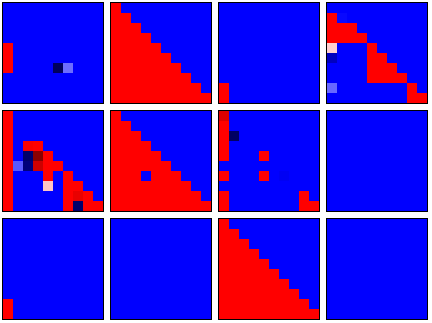

In [147]:
# if only "normal" attention layer implements causal mask
query_length, key_length = q.size(-2), k.size(-2)
causal_mask = attn_0.bias[:, :, key_length - query_length : key_length, :key_length]

mask_value = torch.finfo(attn_weights.dtype).min
mask_value = torch.full([], mask_value, dtype=attn_weights.dtype).to(attn_weights.device)

mask = torch.where(causal_mask, attn_weights, mask_value)

masked_attention_weights = mask
masked_attention_weights.squeeze().chans(scale=10, cmap="seismic")

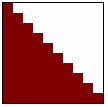

In [148]:
causal_mask.squeeze().chans(scale=10, cmap="seismic")

In [149]:
torch.ones(10, 10)*torch.finfo(torch.float32).min

tensor[10, 10] n=100 x∈[-3.403e+38, -3.403e+38] μ=-inf σ=inf

In [150]:
tt =torch.triu(torch.full((10, 10), float("-inf")), diagonal=1) 

In [151]:
tt.v

tensor[10, 10] n=100 x∈[0., 0.] μ=0. σ=0. -Inf!
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [152]:
mask

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-3.403e+38, 115.081] μ=-inf σ=inf grad WhereBackward0

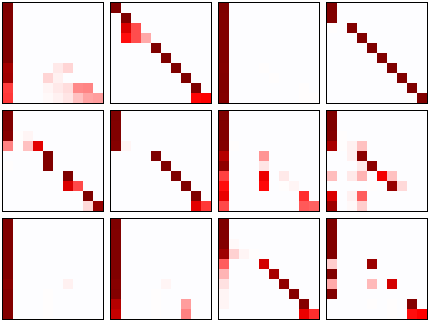

In [153]:
softmax_attention_weights = torch.nn.functional.softmax(masked_attention_weights, dim=-1)
softmax_attention_weights.squeeze().chans(scale=10, cmap="seismic")

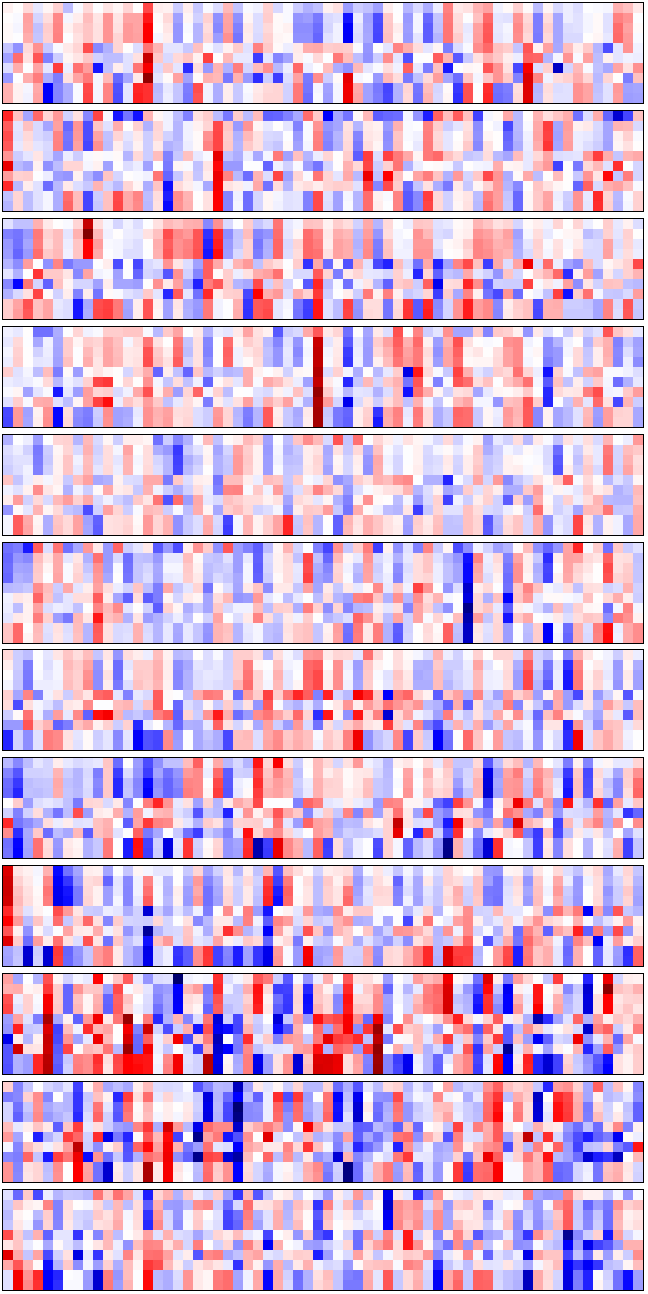

In [154]:
v_split.squeeze().chans(scale=10, cmap="seismic")

In [155]:
import lovely_tensors as lt

In [156]:
lt.set_config(deeper_width=15)
attn_weights.deeper(depth=2)

tensor[1, 12, 10, 10] n=1200 (4.7Kb) x∈[-71.989, 115.081] μ=-1.210 σ=26.638 grad UnsafeViewBackward0
  tensor[12, 10, 10] n=1200 x∈[-71.989, 115.081] μ=-1.210 σ=26.638 grad
    tensor[10, 10] n=100 x∈[-19.798, 7.847] μ=-7.301 σ=5.956 grad
    tensor[10, 10] n=100 x∈[4.808, 104.076] μ=37.603 σ=25.956 grad
    tensor[10, 10] n=100 x∈[-25.035, 2.626] μ=-13.597 σ=6.650 grad
    tensor[10, 10] n=100 x∈[-71.989, 46.959] μ=-4.253 σ=25.962 grad
    tensor[10, 10] n=100 x∈[-18.289, 42.246] μ=3.746 σ=14.215 grad
    tensor[10, 10] n=100 x∈[-5.843, 115.081] μ=42.427 σ=36.203 grad
    tensor[10, 10] n=100 x∈[-15.620, 10.395] μ=-4.760 σ=5.678 grad
    tensor[10, 10] n=100 x∈[-50.371, -3.802] μ=-29.459 σ=10.201 grad
    tensor[10, 10] n=100 x∈[-27.747, 3.366] μ=-14.386 σ=7.266 grad
    tensor[10, 10] n=100 x∈[-36.092, -1.533] μ=-17.969 σ=5.806 grad
    tensor[10, 10] n=100 x∈[-3.550, 33.360] μ=10.468 σ=8.154 grad
    tensor[10, 10] n=100 x∈[-26.247, -3.973] μ=-17.043 σ=4.873 grad

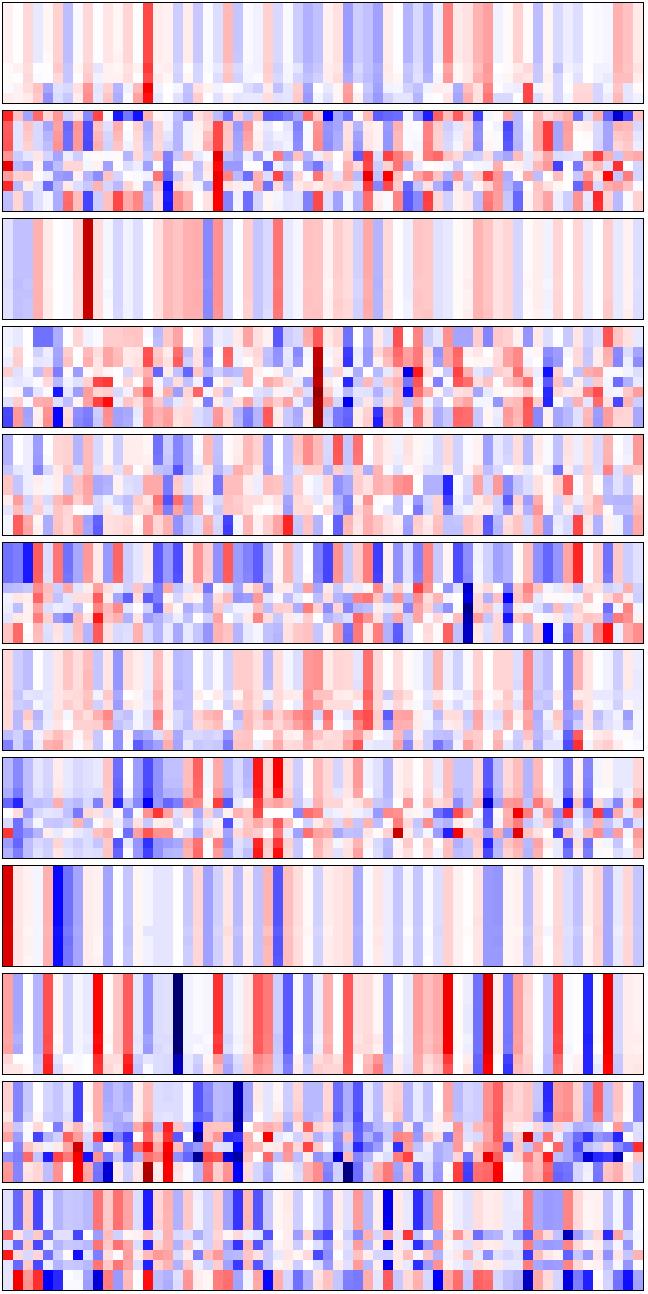

In [157]:
attention_output = torch.matmul(softmax_attention_weights, v_split)
attention_output.squeeze().chans(scale=10, cmap="seismic")

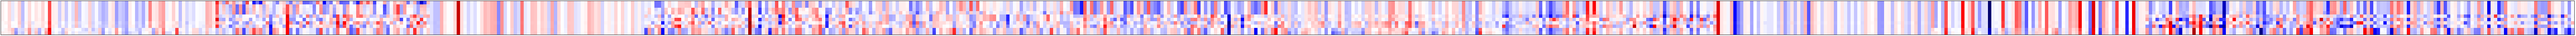

In [158]:
merged_attention_output = attn_0._merge_heads(attention_output, 12, 64)
merged_attention_output.squeeze().chans(scale=10, cmap="seismic")

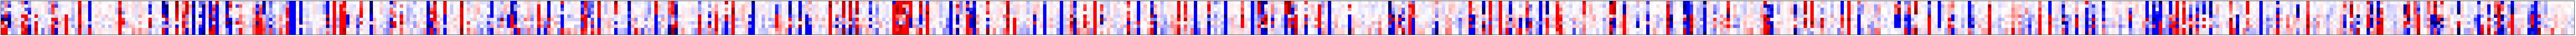

In [159]:
after_mlp = attn_0.c_proj(merged_attention_output)
after_mlp.squeeze().chans(scale=10, cmap="seismic")

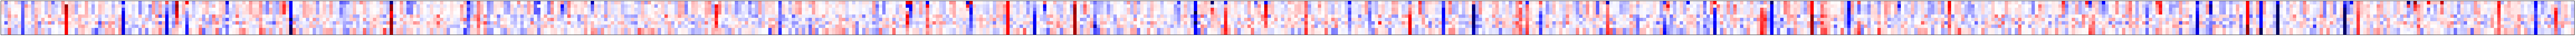

In [85]:
hidden_state_1.squeeze().chans(scale=10, cmap="seismic")

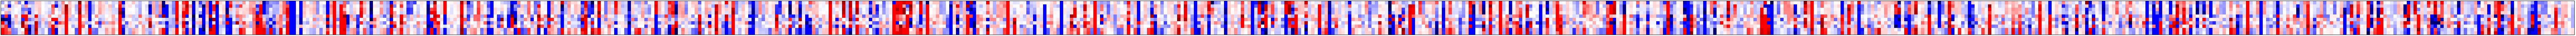

In [87]:
hidden_state_1_res1 = hidden_state_1 + after_mlp
hidden_state_1_res1.squeeze().chans(scale=10, cmap="seismic")

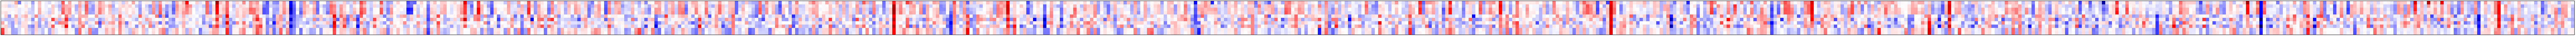

In [89]:
hidden_state_1_res1_ln2 = block0.ln_2(hidden_state_1_res1)
hidden_state_1_res1_ln2.squeeze().chans(scale=10, cmap="seismic")

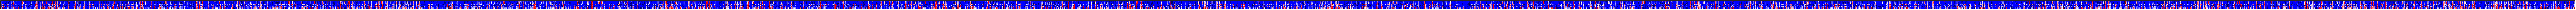

In [93]:
upped = block0.mlp.c_fc(hidden_state_1_res1_ln2)
upped.squeeze().chans(scale=4, cmap="seismic")

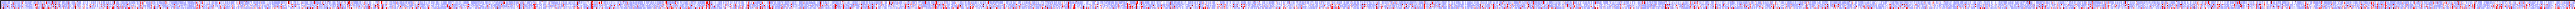

In [94]:
activated = block0.mlp.act(upped)
activated.squeeze().chans(scale=4, cmap="seismic")

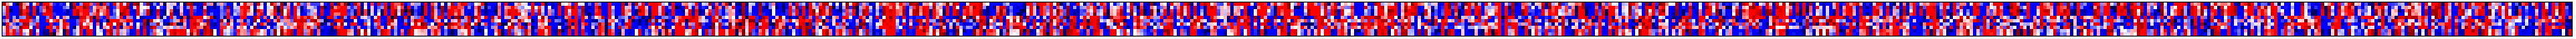

In [95]:
downed = block0.mlp.c_proj(activated)
downed.squeeze().chans(scale=4, cmap="seismic")

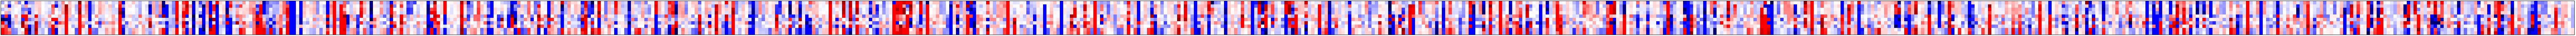

In [97]:
hidden_state_1_res1.squeeze().chans(scale=10, cmap="seismic")

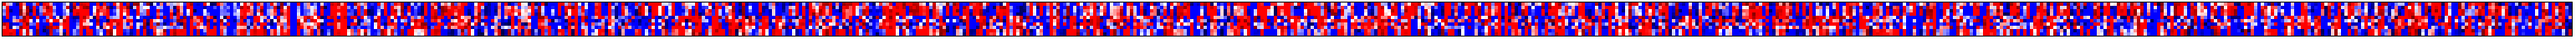

In [96]:
hidden_state_1_out = hidden_state_1_res1 + downed
hidden_state_1_out.squeeze().chans(scale=4, cmap="seismic")

In [1]:
dist = torch.tensor([0.5,0.5,0])

NameError: name 'torch' is not defined

In [162]:
# with torch.no_grad():
#     output = model(**encoded_input)


# encoded_input.attention_mask,
# encoded_input.input_ids
# tokenizer.convert_ids_to_tokens(encoded_input.input_ids[0])
# print(output.last_hidden_state)
# print(output.past_key_values)
# model.config
# dict(output)
# model.config

with no_grad():
    output = model(
        input_ids=encoded_input.input_ids, attention_mask=encoded_input.attention_mask, output_hidden_states=True
    )
dict(output)

{'last_hidden_state': tensor[1, 10, 768] n=7680 (30Kb) x∈[-45.721, 196.593] μ=0.339 σ=7.340,
 'past_key_values': ((tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-6.153, 6.964] μ=0.034 σ=1.383,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-1.561, 1.112] μ=-0.000 σ=0.219),
  (tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-4.565, 3.636] μ=-0.043 σ=1.116,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-3.617, 4.081] μ=-0.001 σ=0.461),
  (tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-6.318, 6.188] μ=-0.033 σ=1.624,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-4.285, 2.873] μ=0.011 σ=0.509),
  (tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-15.817, 13.349] μ=0.050 σ=3.320,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-2.541, 2.226] μ=0.007 σ=0.511),
  (tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-17.436, 19.638] μ=-0.132 σ=3.169,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-2.289, 2.602] μ=0.007 σ=0.555),
  (tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-11.581, 12.464] μ=0.005 σ=1.863,
   tensor[1, 12, 10, 64] n=7680 (30Kb) x∈[-3.083, 4.652] μ